# utils & framework

In [30]:
from collections.abc import Iterable

import scipy.constants
import sympy
from IPython.core.display import Markdown
from sympy import *
from sympy.vector import *

ASSUM = sympy.Q

tag_id = 0
conditions = {}
values = {}
formulas_names = {}
restore_stack = []


def reset():
    global tag_id, conditions, values, formulas_names
    if restore_stack:
        state = restore_stack[-1]
        tag_id = state['tag_id']
        conditions = state['conditions'].copy()
        values = state['values'].copy()
        formulas_names = state['formulas_names'].copy()


def push_state():
    global restore_stack
    restore_stack.append({
        'tag_id': tag_id,
        'conditions': conditions.copy(),
        'values': values.copy(),
        'formulas_names': formulas_names.copy()
    })


def pop_state():
    global restore_stack
    return restore_stack.pop()


def save_as_condition(condition):
    global tag_id, conditions
    cached_condition_id = tag_id
    condition = spf(condition)
    conditions[tag_id] = condition
    tag_id += 1
    return cached_condition_id


def substitute_values(expression, mask=None):
    while True:
        left = False
        items = values.items() if mask is None else filter(lambda item: item[0] in mask, values.items())
        for (key, value) in items:
            before = str(expression)
            expression = expression.subs(key, value)
            expression = simplify(expression)
            if str(expression) != before:
                left = True
        if not left:
            break

    return expression


def save_as_variable(symbol, value):
    global values
    if symbol in values.keys():
        raise ValueError(f"variable {symbol} already exists")
    values[symbol] = substitute_values(S(value))


def save_as_formula_name(symbol, formula):
    global tag_id, formulas_names
    tag_id += 1
    if symbol in formulas_names.keys():
        raise ValueError(f"formula {symbol} already exists")
    formulas_names[symbol] = formula


def beautiful_print(expression, message="", tag=None):
    expression = expression if isinstance(expression, str) else latex(expression)
    inline = not message.endswith('$')
    tag_str = f'\\tag{{{tag}}}' if tag is not None else ""
    if inline:
        full_latex = message + '$' + expression + '$'
    else:
        full_latex = message + '$' + expression + tag_str + '$$'
    display(Markdown(full_latex))


def beautiful_answer(expression, message="$", f: bool = False):
    symbol = expression
    expression = spf(expression)
    expression = expression.evalf() if f else expression
    beautiful_print(Eq(symbol, expression, evaluate=false), message, tag="answer")


def beautiful_inlined(expression, tag=None):
    expression = spf(expression)
    beautiful_print(expression, "inlined:$", tag)


def beautiful_peek(symbol, message="$", tag=None):
    value = spf(symbol)
    beautiful_print(Eq(symbol, value, evaluate=False), message, tag)


def beautiful_solve(cond, variables, apply: dict = None):
    cond = [cond] if not isinstance(cond, Iterable) else cond
    display(Markdown(f"${','.join(f"\\left ( {i} \\right ) " for i in cond)} \\Longrightarrow$"))

    variables = [variables] if not isinstance(variables, Iterable) else variables

    apply = apply if apply is not None else {}

    cond = tuple(map(lambda i: conditions[i].subs(apply), cond))
    cond = map(lambda i: substitute_values(i), cond)
    solution = solve(cond, tuple(variables), dict=True)[0]
    conclusions = []
    for (variable, conclusion) in solution.items():
        beautiful_print(Eq(variable, conclusion), "$")
        save_as_variable(variable, conclusion)
        conclusions.append(conclusion)


def beautiful_condition(expression, message="$"):
    beautiful_print(expression(False) if callable(expression) else expression, message, tag_id)
    return save_as_condition(expression(True) if callable(expression) else expression)


def beautiful_compute(symbol, expression, message="$", tag=None):
    symbol = symbols(symbol) if isinstance(symbol, str) else symbol
    global tag_id
    beautiful_print(Eq(symbol, expression(False) if callable(expression) else expression, evaluate=False), message,
                    tag_id if tag else None)
    if tag:
        tag_id += 1
    save_as_variable(symbol, expression(True) if callable(expression) else expression)
    return symbol


def beautiful_compute_at(symbol, expression, subs: dict, message="$", tag=None):
    symbol = symbols(symbol) if isinstance(symbol, str) else symbol
    global tag_id
    beautiful_print(Eq(symbol, expression.subs(subs), evaluate=False), message,
                    tag_id if tag else None)
    if tag:
        tag_id += 1
    save_as_variable(symbol, substitute_values(expression).subs(subs))
    return symbol


def beautiful_formula(symbol: str, expression: object, message: object = "$", ) -> Any:
    beautiful_print(f"{symbol}=" + latex(expression), message, tag_id)
    save_as_formula_name(expression, symbol)
    return expression


def beautiful_at(formula, subs: dict, message="$", tag: bool = None):
    result = simplify(formula.subs(subs))
    param = '\\,'.join(f"{latex(item[0])}={latex(item[1])}" for item in subs.items())
    beautiful_print(formulas_names[formula] + f"\\bigg|_{{{param}}}=" + latex(result), message, tag)
    return result


def spf(expression):
    expression = substitute_values(expression)
    expression = simplify(expression)
    expression = expression.doit()
    return expression


class D:
    def __init__(self, symbol: Symbol, name: str = None):
        symbol = 'd' + latex(symbol) if name is None else name
        self.symbol = Symbol(symbol)

    def __enter__(self):
        return self.symbol

    def __exit__(self, type, value, traceback):
        save_as_variable(self.symbol, 1)


def map_vector(vec, func):
    return sum(
        # 0 is i/j/k sharp, 1 is expr
        map(lambda item: func(item[1]) * item[0], vec.components.items()),
        Vector.zero
    )


def series_vector(vec, param, x0=0, n=2):
    return map_vector(vec, lambda e: series(e, param, x0, n).removeO())


def integrate_vector(vec, param):
    return map_vector(vec, lambda e: integrate(e, param))


def md(msg):
    display(Markdown(msg))


def beautiful_vector(xi=0, yj=0, zk=0):
    xi = Symbol(xi) if isinstance(xi, str) else xi
    yj = Symbol(yj) if isinstance(yj, str) else yj
    zk = Symbol(zk) if isinstance(zk, str) else zk
    return xi * coord.i + yj * coord.j + zk * coord.k


def beautiful_branch_at(expression, index):
    expression = spf(expression)
    branch, cond = expression.args[index]
    return branch


def refine_piecewise(pw_expr, assume):
    pw_expr = spf(pw_expr)

    for expr_val, cond in pw_expr.args:
        if ask(cond, assume):
            return refine(expr_val, assume)

    # If no branch can be definitively chosen, refine each branch
    refined_args = [(refine(expr_val, assume), cond)
                    for expr_val, cond in pw_expr.args]
    return Piecewise(*refined_args)


coord = CoordSys3D('')

## Common

In [31]:
epsilon_0 = symbols('epsilon_0', positive=True)
k = 1 / (4 * pi * epsilon_0)
charge = symbols('q')
x = coord.x
y = coord.y
z = coord.z
pos = x * coord.i + y * coord.j + z * coord.k
E = beautiful_formula('E', k * charge * pos / pos.magnitude() ** 3, "by Coulomb's law:$")
electric_flux = Symbol('phi_e')
enclosed_charge_sum = Symbol('Q_{sum}')
Gauss_law = beautiful_condition(Eq(electric_flux, enclosed_charge_sum / epsilon_0), "by Gauss's law:$")


def fn_potential(q, r):
    return k * q / r


P = beautiful_formula('\\varphi', fn_potential(charge, pos.magnitude()), 'electric potential:$')


def save_common_consts():
    save_as_variable(epsilon_0, scipy.constants.epsilon_0)
    save_as_variable(pi, scipy.constants.pi)


push_state()

by Coulomb's law:$$E=\left(\frac{\mathbf{{x}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\mathbf{{z}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{k}_{}}\tag{0}$$

by Gauss's law:$$\phi_{e} = \frac{Q_{sum}}{\epsilon_{0}}\tag{1}$$

electric potential:$$\varphi=\frac{q}{4 \pi \epsilon_{0} \sqrt{\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}}}\tag{2}$$

# 15.2
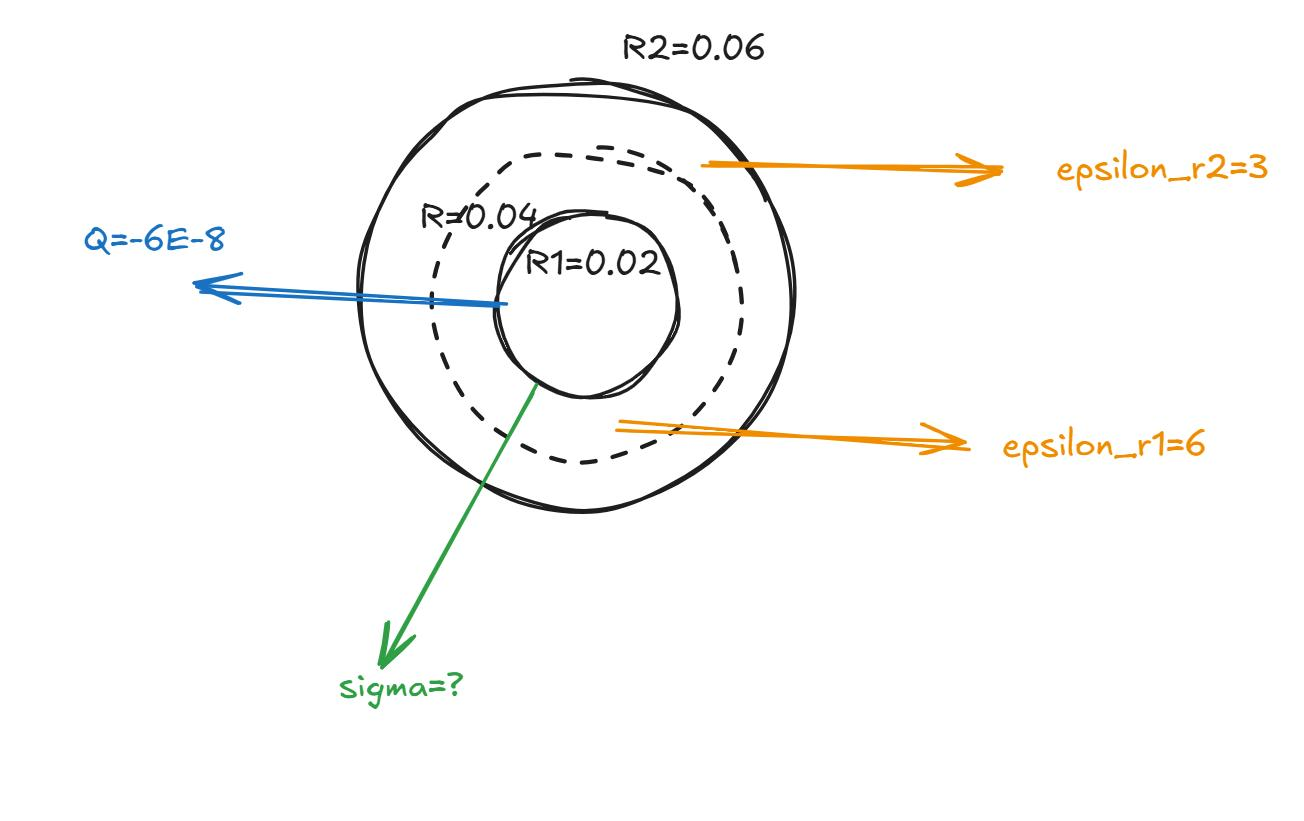

In [32]:
reset()


def t152():
    Q, R1, R2, R, epsilon_r1, epsilon_r2, sigma = symbols('Q R1 R2 R epsilon_r1 epsilon_r2 sigma', positive=True)
    save_as_variable(Q, -6E-8)
    save_as_variable(R, 0.04)
    save_as_variable(R1, 0.02)
    save_as_variable(R2, 0.06)
    save_as_variable(epsilon_r1, 6)
    save_as_variable(epsilon_r2, 3)
    save_common_consts()

    r = Symbol('r', positive=True)
    D = Function('D')(r)
    E = Function('E')(r)
    xxxx = Piecewise((epsilon_0, r < R1),
                     (epsilon_0 * epsilon_r1, (r <= R)),
                     (epsilon_r2 * epsilon_0, (r <= R2)),
                     (epsilon_0, (r > R2)))
    epsilon = beautiful_compute(Function('epsilon')(r), xxxx, "given:$")
    beautiful_compute(E, D / epsilon, "by define:$")
    beautiful_peek(E, "inlined:$")

    c1 = beautiful_condition(Eq(4 * pi * r ** 2 * D, Q), "by gauss:$")
    beautiful_solve(c1, D)
    beautiful_answer(E)

    U = beautiful_compute(Symbol('U'), integrate(E, (r, R1, R2)))
    beautiful_answer(U)

    E_1 = beautiful_compute_at(Symbol('E_1'), E, {r: R1}, "near sphere1:$")
    beautiful_peek(E_1, "inlined:$")
    P = beautiful_compute('sigma', epsilon_0 * (epsilon_r1 - 1) * E_1, " by define:$")
    beautiful_answer(P)


t152()

given:$$\epsilon{\left(r \right)} = \begin{cases} \epsilon_{0} & \text{for}\: R_{1} > r \\\epsilon_{0} \epsilon_{r1} & \text{for}\: R \geq r \\\epsilon_{0} \epsilon_{r2} & \text{for}\: R_{2} \geq r \\\epsilon_{0} & \text{otherwise} \end{cases}$$

by define:$$E{\left(r \right)} = \frac{D{\left(r \right)}}{\epsilon{\left(r \right)}}$$

inlined:$$E{\left(r \right)} = \begin{cases} 112940906660.768 D{\left(r \right)} & \text{for}\: r < 0.02 \\18823484443.4613 D{\left(r \right)} & \text{for}\: r \leq 0.04 \\37646968886.9227 D{\left(r \right)} & \text{for}\: r \leq 0.06 \\112940906660.768 D{\left(r \right)} & \text{otherwise} \end{cases}$$

by gauss:$$4 \pi r^{2} D{\left(r \right)} = Q\tag{3}$$

$\left ( 3 \right )  \Longrightarrow$

$$D{\left(r \right)} = - \frac{4.77464829275685 \cdot 10^{-9}}{r^{2}}$$

$$E{\left(r \right)} = \begin{cases} - \frac{539.253107170247}{r^{2}} & \text{for}\: r < 0.02 \\- \frac{89.8755178617078}{r^{2}} & \text{for}\: r \leq 0.04 \\- \frac{179.751035723416}{r^{2}} & \text{for}\: r \leq 0.06 \\- \frac{539.253107170247}{r^{2}} & \text{otherwise} \end{cases}\tag{answer}$$

$$U = \int\limits_{R_{1}}^{R_{2}} E{\left(r \right)}\, dr$$

$$U = -3744.81324423782\tag{answer}$$

near sphere1:$$E_{1} = E{\left(R_{1} \right)}$$

inlined:$$E_{1} = -224688.794654269$$

 by define:$$\sigma = E_{1} \epsilon_{0} \left(\epsilon_{r1} - 1\right)$$

$$\sigma = -9.94718394324344 \cdot 10^{-6}\tag{answer}$$

# 15.3
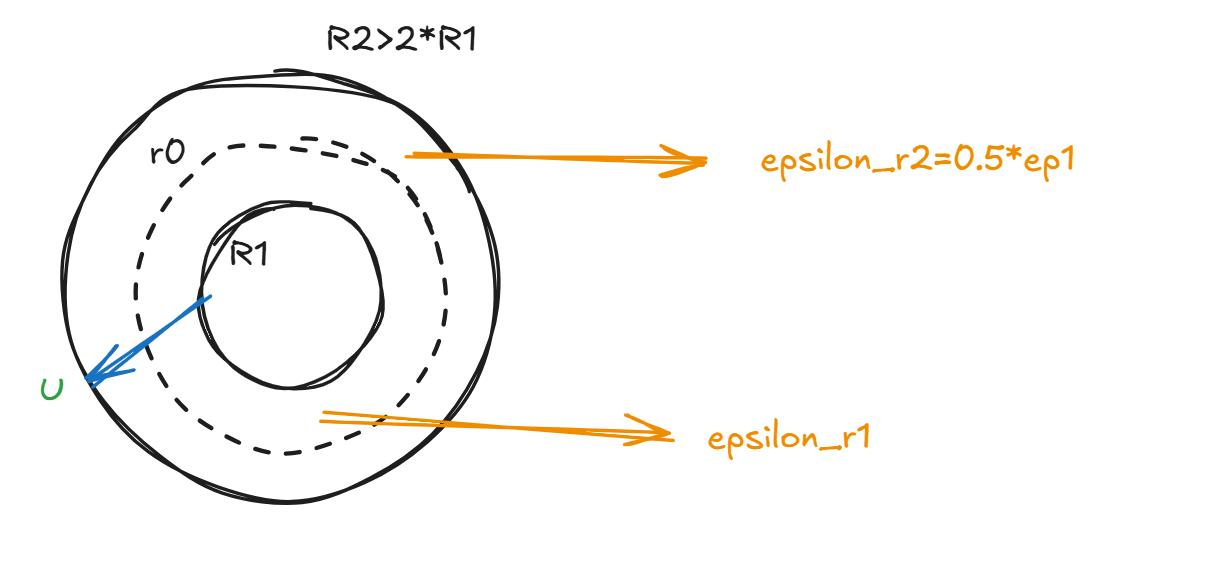

In [33]:
reset()


def t153():
    R1, R2, r0, epsilon_r1, epsilon_r2, U = symbols('R1 R2 r0 epsilon_r1 epsilon_r2 U', positive=True)

    beautiful_compute(epsilon_r2, epsilon_r1 / 2, "given:$")
    r = Symbol('r', positive=True)
    Q = symbols('Q')
    D = Function('D')(r)
    E = Function('E')(r)
    xxxx = Piecewise((epsilon_0, r < R1),
                     (epsilon_0 * epsilon_r1, (r <= r0)),
                     (epsilon_r2 * epsilon_0, (r <= R2)),
                     (epsilon_0, (r > R2)))
    epsilon = beautiful_compute(Function('epsilon')(r), xxxx, "given:$")
    beautiful_compute(E, D / epsilon, "by define:$")
    beautiful_peek(E, "inlined:$")

    c1 = beautiful_condition(Eq(2 * pi * r * D, Q), "by gauss:$")
    beautiful_solve(c1, D)

    md("so $E_{max}$ happens on r2")
    E_max = Symbol("E_{max}")
    E_2 = beautiful_compute_at('E_2', beautiful_branch_at(E, 2), {r: R2})
    beautiful_peek(E_2, "inlined:$")
    c1 = beautiful_condition(Eq(E_max, E_2))

    beautiful_solve(c1, Q)

    beautiful_answer(E)

    U = beautiful_compute(Symbol('U'), integrate(E, (r, R1, R2)))
    beautiful_peek(U)
    U = refine_piecewise(U, ASSUM.lt(R1, r0) & ASSUM.lt
    (r0, R2))


    beautiful_inlined(U, "answer")
    print(spf(U))



t153()

given:$$\epsilon_{r2} = \frac{\epsilon_{r1}}{2}$$

given:$$\epsilon{\left(r \right)} = \begin{cases} \epsilon_{0} & \text{for}\: R_{1} > r \\\epsilon_{0} \epsilon_{r1} & \text{for}\: r \leq r_{0} \\\epsilon_{0} \epsilon_{r2} & \text{for}\: R_{2} \geq r \\\epsilon_{0} & \text{otherwise} \end{cases}$$

by define:$$E{\left(r \right)} = \frac{D{\left(r \right)}}{\epsilon{\left(r \right)}}$$

inlined:$$E{\left(r \right)} = \begin{cases} \frac{D{\left(r \right)}}{\epsilon_{0}} & \text{for}\: R_{1} > r \\\frac{D{\left(r \right)}}{\epsilon_{0} \epsilon_{r1}} & \text{for}\: r \leq r_{0} \\\frac{2 D{\left(r \right)}}{\epsilon_{0} \epsilon_{r1}} & \text{for}\: R_{2} \geq r \\\frac{D{\left(r \right)}}{\epsilon_{0}} & \text{otherwise} \end{cases}$$

by gauss:$$2 \pi r D{\left(r \right)} = Q\tag{3}$$

$\left ( 3 \right )  \Longrightarrow$

$$D{\left(r \right)} = \frac{Q}{2 \pi r}$$

so $E_{max}$ happens on r2

$$E_{2} = \frac{Q}{\pi R_{2} \epsilon_{0} \epsilon_{r1}}$$

inlined:$$E_{2} = \frac{Q}{\pi R_{2} \epsilon_{0} \epsilon_{r1}}$$

$$E_{max} = E_{2}\tag{4}$$

$\left ( 4 \right )  \Longrightarrow$

$$Q = \pi E_{max} R_{2} \epsilon_{0} \epsilon_{r1}$$

$$E{\left(r \right)} = \begin{cases} \frac{E_{max} R_{2} \epsilon_{r1}}{2 r} & \text{for}\: R_{1} > r \\\frac{E_{max} R_{2}}{2 r} & \text{for}\: r \leq r_{0} \\\frac{E_{max} R_{2}}{r} & \text{for}\: R_{2} \geq r \\\frac{E_{max} R_{2} \epsilon_{r1}}{2 r} & \text{otherwise} \end{cases}\tag{answer}$$

$$U = \int\limits_{R_{1}}^{R_{2}} E{\left(r \right)}\, dr$$

$$U = \begin{cases} - \frac{E_{max} R_{2} \log{\left(R_{1} \right)}}{2} + E_{max} R_{2} \log{\left(R_{2} \right)} - \frac{E_{max} R_{2} \log{\left(\min\left(R_{2}, \max\left(R_{1}, r_{0}\right)\right) \right)}}{2} & \text{for}\: R_{1} < R_{2} \\- \frac{E_{max} R_{2} \epsilon_{r1} \log{\left(R_{1} \right)}}{2} + \frac{E_{max} R_{2} \epsilon_{r1} \log{\left(R_{2} \right)}}{2} & \text{otherwise} \end{cases}$$

inlined:$$E_{max} \log{\left(\left(\frac{R_{2}^{2}}{R_{1} \min\left(R_{2}, \max\left(R_{1}, r_{0}\right)\right)}\right)^{\frac{R_{2}}{2}} \right)}\tag{answer}$$

E_{max}*log((R2**2/(R1*Min(R2, Max(R1, r0))))**(R2/2))


that is :
$$
\boxed{E_{\text{max}} \cdot \frac{R2}{2} \cdot \log\left( \frac{R2^2}{R1\, r0} \right)}
$$

# 15.14
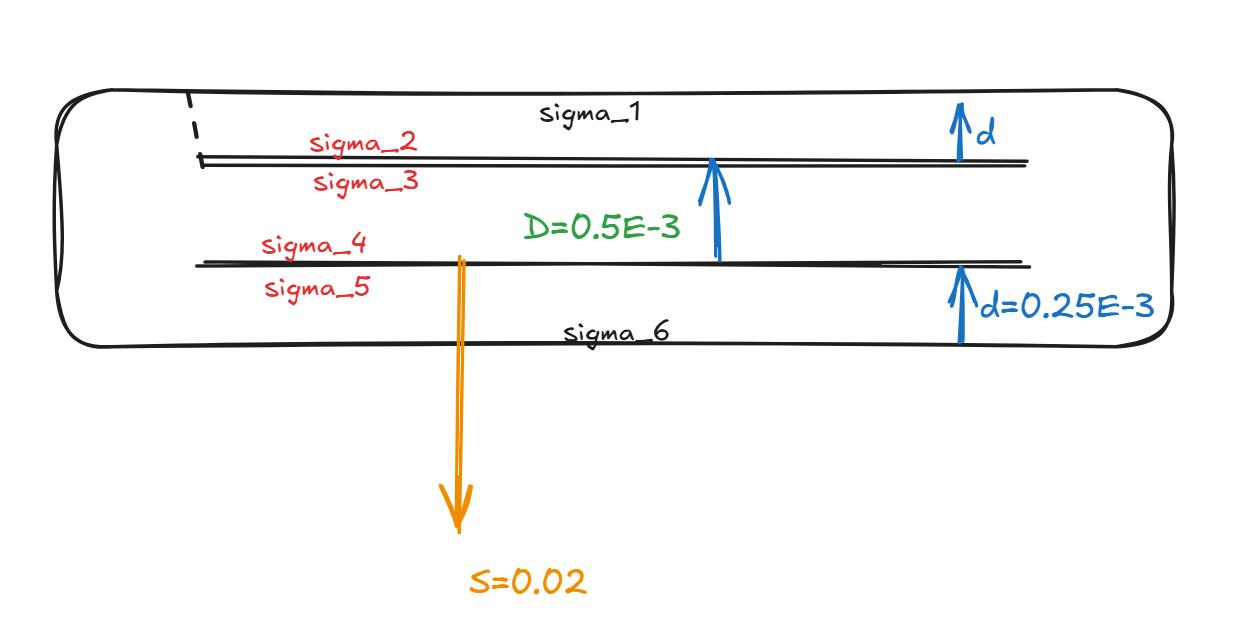


In [34]:
reset()


def t15141():
    D, d, S = symbols('D d S')
    save_as_variable(D, 0.5 * 1E-3)
    save_as_variable(d, 0.25 * 1E-3)
    save_as_variable(S, 0.02)
    save_common_consts()
    sigma_1, sigma_2, sigma_3, sigma_4, sigma_5, sigma_6 = symbols('sigma_1 sigma_2 sigma_3 sigma_4 sigma_5 sigma_6')
    q = Symbol('q')
    c1 = beautiful_condition(Eq(sigma_4 + sigma_5 + sigma_1 + sigma_2 + sigma_3 + sigma_6, 0), "by zero charge sum:$")
    c2 = beautiful_condition(Eq(sigma_4 + sigma_5, -q / S))
    c5 = beautiful_condition(Eq(sigma_2 + sigma_3, q / S))
    c6 = beautiful_condition(
        Eq(+sigma_6 * (D + d + d) + (sigma_4 + sigma_5) * D - (sigma_2 + sigma_3) * (D) - sigma_1 * (D + d + d),
           0), "by zero potential diff between box top and bottom:$")
    c3 = beautiful_condition(Eq(sigma_1 + sigma_2, sigma_3 + sigma_4 + sigma_5 + sigma_6), "by upper board zero E:$")
    c4 = beautiful_condition(Eq(sigma_1 + sigma_2 + sigma_3 + sigma_4, sigma_5 + sigma_6), "by lower board zero E:$")

    beautiful_solve([c1, c2, c3, c4, c5, c6], [sigma_1, sigma_2, sigma_3, sigma_4, sigma_5, sigma_6])

    def Eboard(dense):
        return dense / (2 * epsilon_0)

    E = beautiful_compute('E', Eboard(sigma_1 + sigma_2 + sigma_3 - sigma_4 - sigma_5 - sigma_6))
    beautiful_inlined(E)
    U = beautiful_compute('U', E * D)
    C = beautiful_compute('C', q / U)
    beautiful_answer(C)


t15141()
md("-------------------------------")
reset()


def t1514():
    D, d, S = symbols('D d S')
    save_as_variable(D, 0.5 * 1E-3)
    save_as_variable(d, 0.25 * 1E-3)
    save_as_variable(S, 0.02)
    save_common_consts()
    sigma_1, sigma_2, sigma_3, sigma_4, sigma_5, sigma_6 = symbols('sigma_1 sigma_2 sigma_3 sigma_4 sigma_5 sigma_6')
    q = Symbol('q')
    c1 = beautiful_condition(Eq(sigma_4 + sigma_5 + sigma_1 + sigma_2 + sigma_3 + sigma_6, 0), "by zero charge sum:$")
    c2 = beautiful_condition(Eq(sigma_4 + sigma_5, -q / S))
    c3 = beautiful_condition(Eq(sigma_1 + sigma_2, sigma_3 + sigma_4 + sigma_5 + sigma_6), "by upper board zero E:$")
    c4 = beautiful_condition(Eq(sigma_1 + sigma_2 + sigma_3 + sigma_4, sigma_5 + sigma_6), "by lower board zero E:$")
    c5 = beautiful_condition(
        Eq((-sigma_1) * d + (sigma_2 + sigma_3) * d + (sigma_4 + sigma_5) * (d + D) + sigma_6 * (D + d + d), 0),
        "by connect box and upper board, zero potential:$")
    c6 = beautiful_condition(
        Eq(+sigma_6 * (D + d + d) + (sigma_4 + sigma_5) * D - (sigma_2 + sigma_3) * (D) - sigma_1 * (D + d + d),
           0), "by zero potential diff between box top and bottom:$")
    beautiful_solve([c1, c2, c3, c4, c5, c6], [sigma_1, sigma_2, sigma_3, sigma_4, sigma_5, sigma_6])

    def Eboard(dense):
        return dense / (2 * epsilon_0)

    E = beautiful_compute('E', Eboard(sigma_1 + sigma_2 + sigma_3 - sigma_4 - sigma_5 - sigma_6))
    beautiful_inlined(E)
    U = beautiful_compute('U', E * D)
    C = beautiful_compute('C', q / U)
    beautiful_answer(C)


t1514()


by zero charge sum:$$\sigma_{1} + \sigma_{2} + \sigma_{3} + \sigma_{4} + \sigma_{5} + \sigma_{6} = 0\tag{3}$$

$$\sigma_{4} + \sigma_{5} = - \frac{q}{S}\tag{4}$$

$$\sigma_{2} + \sigma_{3} = \frac{q}{S}\tag{5}$$

by zero potential diff between box top and bottom:$$- D \left(\sigma_{2} + \sigma_{3}\right) + D \left(\sigma_{4} + \sigma_{5}\right) - \sigma_{1} \left(D + 2 d\right) + \sigma_{6} \left(D + 2 d\right) = 0\tag{6}$$

by upper board zero E:$$\sigma_{1} + \sigma_{2} = \sigma_{3} + \sigma_{4} + \sigma_{5} + \sigma_{6}\tag{7}$$

by lower board zero E:$$\sigma_{1} + \sigma_{2} + \sigma_{3} + \sigma_{4} = \sigma_{5} + \sigma_{6}\tag{8}$$

$\left ( 3 \right ) ,\left ( 4 \right ) ,\left ( 7 \right ) ,\left ( 8 \right ) ,\left ( 5 \right ) ,\left ( 6 \right )  \Longrightarrow$

$$\sigma_{1} = - 25.0 q$$

$$\sigma_{2} = 25.0 q$$

$$\sigma_{3} = 25.0 q$$

$$\sigma_{4} = - 25.0 q$$

$$\sigma_{5} = - 25.0 q$$

$$\sigma_{6} = 25.0 q$$

$$E = \frac{\sigma_{1} + \sigma_{2} + \sigma_{3} - \sigma_{4} - \sigma_{5} - \sigma_{6}}{2 \epsilon_{0}}$$

inlined:$$2823522666519.2 q$$

$$U = D E$$

$$C = \frac{q}{U}$$

$$C = 7.08335025504 \cdot 10^{-10}\tag{answer}$$

-------------------------------

by zero charge sum:$$\sigma_{1} + \sigma_{2} + \sigma_{3} + \sigma_{4} + \sigma_{5} + \sigma_{6} = 0\tag{3}$$

$$\sigma_{4} + \sigma_{5} = - \frac{q}{S}\tag{4}$$

by upper board zero E:$$\sigma_{1} + \sigma_{2} = \sigma_{3} + \sigma_{4} + \sigma_{5} + \sigma_{6}\tag{5}$$

by lower board zero E:$$\sigma_{1} + \sigma_{2} + \sigma_{3} + \sigma_{4} = \sigma_{5} + \sigma_{6}\tag{6}$$

by connect box and upper board, zero potential:$$- d \sigma_{1} + d \left(\sigma_{2} + \sigma_{3}\right) + \sigma_{6} \left(D + 2 d\right) + \left(D + d\right) \left(\sigma_{4} + \sigma_{5}\right) = 0\tag{7}$$

by zero potential diff between box top and bottom:$$- D \left(\sigma_{2} + \sigma_{3}\right) + D \left(\sigma_{4} + \sigma_{5}\right) - \sigma_{1} \left(D + 2 d\right) + \sigma_{6} \left(D + 2 d\right) = 0\tag{8}$$

$\left ( 3 \right ) ,\left ( 4 \right ) ,\left ( 5 \right ) ,\left ( 6 \right ) ,\left ( 7 \right ) ,\left ( 8 \right )  \Longrightarrow$

$$\sigma_{1} = 0.0$$

$$\sigma_{2} = 0.0$$

$$\sigma_{3} = 16.6666666666667 q$$

$$\sigma_{4} = - 16.6666666666667 q$$

$$\sigma_{5} = - 33.3333333333333 q$$

$$\sigma_{6} = 33.3333333333333 q$$

$$E = \frac{\sigma_{1} + \sigma_{2} + \sigma_{3} - \sigma_{4} - \sigma_{5} - \sigma_{6}}{2 \epsilon_{0}}$$

inlined:$$1882348444346.13 q$$

$$U = D E$$

$$C = \frac{q}{U}$$

$$C = 1.062502538256 \cdot 10^{-9}\tag{answer}$$

# 1515
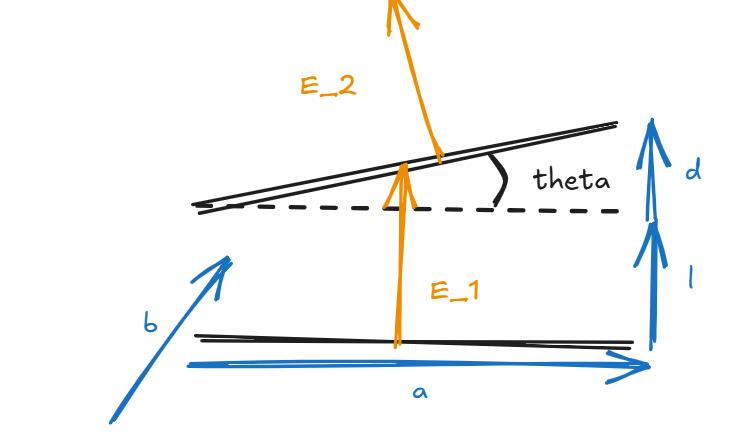

In [35]:
reset()


def t1515():
    theta, d, l, b, a = symbols('theta d l b a', positive=True)
    c1 = beautiful_condition(Eq(a * tan(theta), d))
    beautiful_solve(c1, theta)

    q = Symbol('q')

    def Eboard(dense):
        return dense / (2 * epsilon_0)

    S = beautiful_compute('S', a * b)
    E_1 = beautiful_compute('E_1', Eboard(q / S))
    E_2 = beautiful_compute('E_2', Eboard(q / S) * cos(theta))
    E = beautiful_compute('E', E_1 + E_2)
    beautiful_inlined(E)
    U = beautiful_compute('U', E * (l + d / 2))
    C = beautiful_compute('C', q / U)
    beautiful_answer(C)
    md("to approx it:")
    dx = symbols('dx')
    C = spf(C).subs(d, dx * l)
    beautiful_print(C, "for this expr:$")
    C = C.series(dx, 0, 2)
    beautiful_print(C, "series to 3nd:$")

    beautiful_print(C.removeO().subs(dx, d / l), "so :$")


t1515()

$$a \tan{\left(\theta \right)} = d\tag{3}$$

$\left ( 3 \right )  \Longrightarrow$

$$\theta = \operatorname{atan}{\left(\frac{d}{a} \right)}$$

$$S = a b$$

$$E_{1} = \frac{q}{2 S \epsilon_{0}}$$

$$E_{2} = \frac{q \cos{\left(\theta \right)}}{2 S \epsilon_{0}}$$

$$E = E_{1} + E_{2}$$

inlined:$$\frac{q}{2 b \epsilon_{0} \sqrt{a^{2} + d^{2}}} + \frac{q}{2 a b \epsilon_{0}}$$

$$U = E \left(\frac{d}{2} + l\right)$$

$$C = \frac{q}{U}$$

$$C = \frac{4 a b \epsilon_{0} \sqrt{a^{2} + d^{2}}}{\left(a + \sqrt{a^{2} + d^{2}}\right) \left(d + 2 l\right)}\tag{answer}$$

to approx it:

for this expr:$$\frac{4 a b \epsilon_{0} \sqrt{a^{2} + dx^{2} l^{2}}}{\left(a + \sqrt{a^{2} + dx^{2} l^{2}}\right) \left(dx l + 2 l\right)}$$

series to 3nd:$$\frac{a b \epsilon_{0}}{l} - \frac{a b dx \epsilon_{0}}{2 l} + O\left(dx^{2}\right)$$

so :$$- \frac{a b d \epsilon_{0}}{2 l^{2}} + \frac{a b \epsilon_{0}}{l}$$

# 15.19
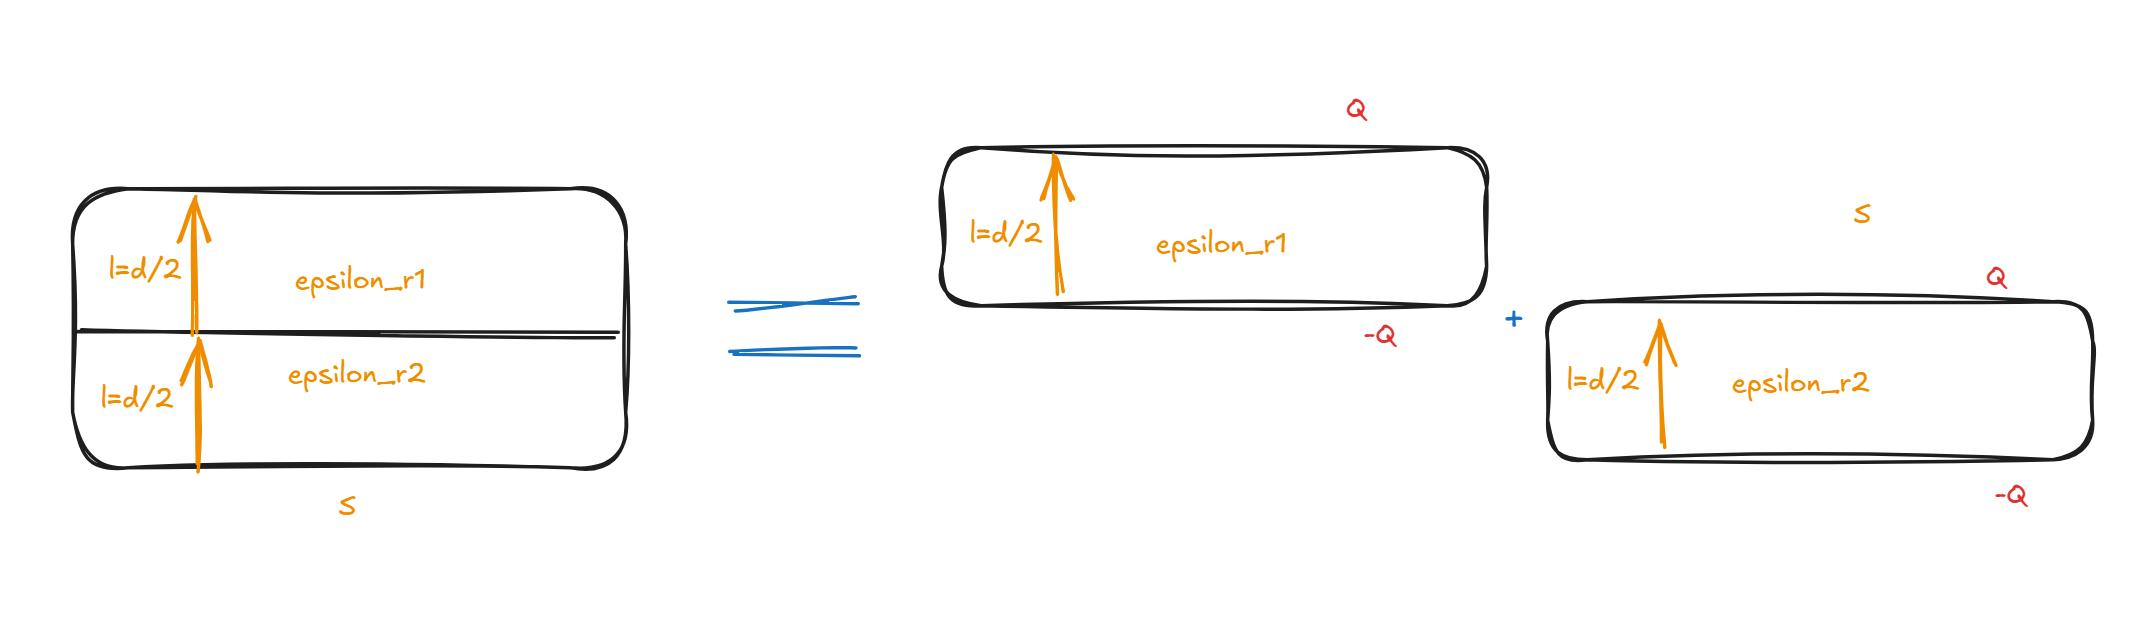

In [36]:
reset()


def t1519():
    Q, epsilon_r1, epsilon_r2 = symbols('Q epsilon_r1 epsilon_r2')
    md("we do the middle apart and got a reasonable charge distribution as the above")
    d = symbols('d')
    S = symbols('S')

    def Eboard(dense):
        return dense / (epsilon_0)

    l = beautiful_compute('l', d / 2, )
    U_1, U_2, C_1, C_2 = symbols('U_1 U_2 C_1 C_2')
    beautiful_compute(U_1, l * Eboard(Q / S) / epsilon_r1)
    beautiful_compute(U_2, l * Eboard(Q / S) / epsilon_r2)
    U = beautiful_compute('U', U_1 + U_2)
    beautiful_peek(U)
    C = beautiful_compute('C', Q / U)
    beautiful_answer(C)


t1519()

we do the middle apart and got a reasonable charge distribution as the above

$$l = \frac{d}{2}$$

$$U_{1} = \frac{Q l}{S \epsilon_{0} \epsilon_{r1}}$$

$$U_{2} = \frac{Q l}{S \epsilon_{0} \epsilon_{r2}}$$

$$U = U_{1} + U_{2}$$

$$U = \frac{Q d \left(\epsilon_{r1} + \epsilon_{r2}\right)}{2 S \epsilon_{0} \epsilon_{r1} \epsilon_{r2}}$$

$$C = \frac{Q}{U}$$

$$C = \frac{2 S \epsilon_{0} \epsilon_{r1} \epsilon_{r2}}{d \left(\epsilon_{r1} + \epsilon_{r2}\right)}\tag{answer}$$